<a href="https://colab.research.google.com/github/JoJa171199/INESDI_Data-Science_ML_IA/blob/main/%5B06%5D%20-%20Deep%20Learning/MLP_Basic_Ttitanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio Práctico: Perceptrón Multicapa (MLP) con Dataset Titanic

## Máster de FP en Business Analytics e Inteligencia Artificial
### Módulo: Data Analytics - Data Science, Machine Learning e IA
### Profesores: Álvaro López

## ¿Qué problema vamos a resolver?
El problema consiste en **predecir si un pasajero sobrevivió** (`Survived` = 1) o no (`Survived` = 0) al naufragio del Titanic, en función de características como clase del billete, edad, sexo, etc.

**Tipo de problema:** Clasificación binaria.

**Métricas clave:**
- **Accuracy** (exactitud): proporción de aciertos sobre el total.
- **Precision/Recall/F1**: útiles cuando nos preocupa más un tipo de error.
- **Matriz de confusión**: tabla que muestra aciertos/errores por clase.

## 1. Instalación y Carga de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings('ignore')

print('Librerías cargadas correctamente')
print(f'TensorFlow versión: {tf.__version__}')

Librerías cargadas correctamente
TensorFlow versión: 2.19.0


## 2. Carga y Exploración del Dataset

Usaremos un CSV público mantenido por la comunidad. **No necesitas cuenta ni claves**.

**Fuente sugerida:** `https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv`

In [2]:
df = sns.load_dataset('titanic')

print('Dataset Titanic cargado')
print(f'Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas')
display(df.head())

print('\nInformación del Dataset:')
df.info()

Dataset Titanic cargado
Dimensiones: 891 filas x 15 columnas


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True



Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [3]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Faltantes': missing[missing > 0],
    'Porcentaje': missing_pct[missing > 0]
}).sort_values('Porcentaje', ascending=False)

print('Valores Faltantes:')
display(missing_df)

Valores Faltantes:


,Valores Faltantes,Porcentaje
deck,688,77.216611
age,177,19.865320
embarked,2,0.224467
embark_town,2,0.224467


## 3. Análisis Exploratorio (EDA)

Objetivo: detectar **columnas útiles**, valores nulos y la **distribución de la variable objetivo**.

Para un curso introductorio, basta con una exploración ligera.

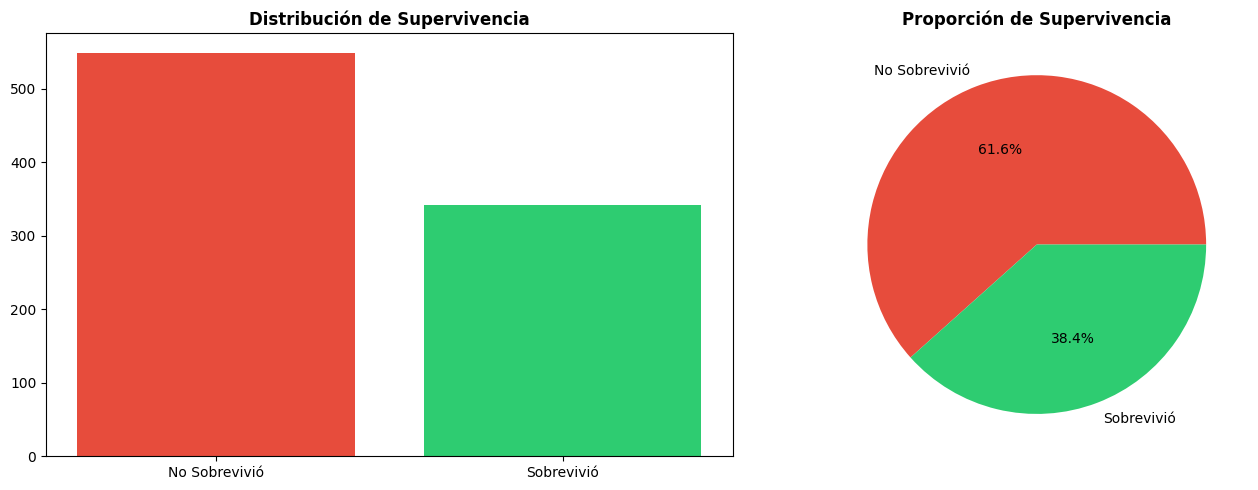

Tasa de Supervivencia: 38.38%


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

survival_counts = df['survived'].value_counts()
axes[0].bar(['No Sobrevivió', 'Sobrevivió'], survival_counts.values, color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Distribución de Supervivencia', fontweight='bold')

axes[1].pie(survival_counts.values, labels=['No Sobrevivió', 'Sobrevivió'], autopct='%1.1f%%', colors=['#e74c3c', '#2ecc71'])
axes[1].set_title('Proporción de Supervivencia', fontweight='bold')

plt.tight_layout()
plt.show()

print(f'Tasa de Supervivencia: {survival_counts[1]/len(df)*100:.2f}%')

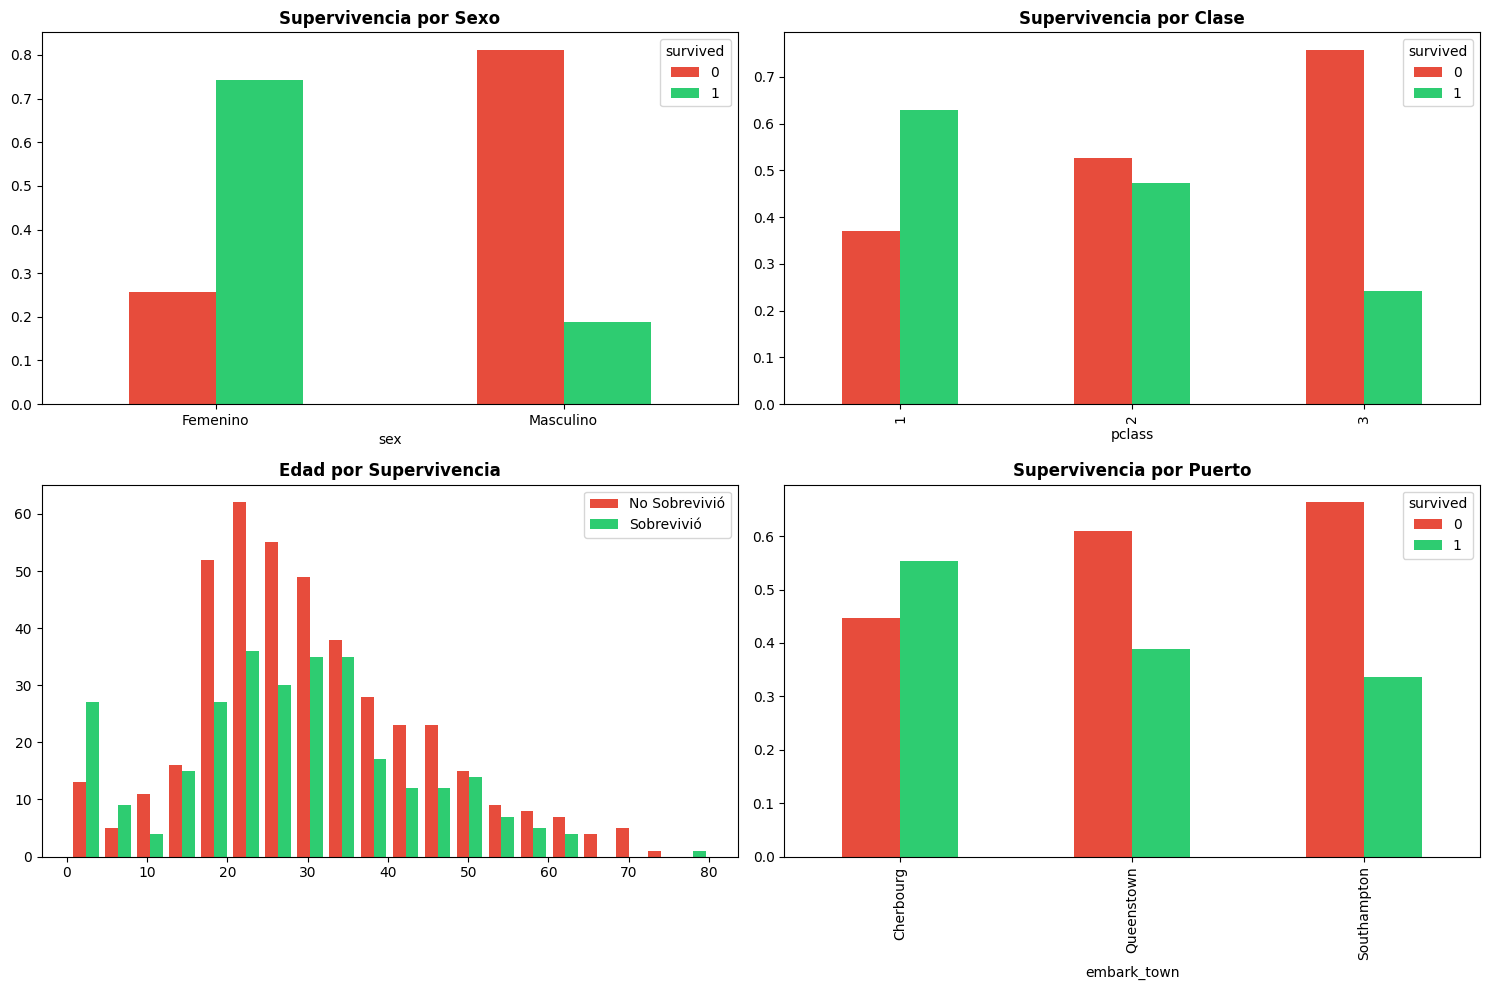

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

pd.crosstab(df['sex'], df['survived'], normalize='index').plot(kind='bar', ax=axes[0, 0], color=['#e74c3c', '#2ecc71'])
axes[0, 0].set_title('Supervivencia por Sexo', fontweight='bold')
axes[0, 0].set_xticklabels(['Femenino', 'Masculino'], rotation=0)

pd.crosstab(df['pclass'], df['survived'], normalize='index').plot(kind='bar', ax=axes[0, 1], color=['#e74c3c', '#2ecc71'])
axes[0, 1].set_title('Supervivencia por Clase', fontweight='bold')

df_age = df.dropna(subset=['age'])
axes[1, 0].hist([df_age[df_age['survived']==0]['age'], df_age[df_age['survived']==1]['age']], bins=20, label=['No Sobrevivió', 'Sobrevivió'], color=['#e74c3c', '#2ecc71'])
axes[1, 0].set_title('Edad por Supervivencia', fontweight='bold')
axes[1, 0].legend()

pd.crosstab(df['embark_town'].dropna(), df[df['embark_town'].notna()]['survived'], normalize='index').plot(kind='bar', ax=axes[1, 1], color=['#e74c3c', '#2ecc71'])
axes[1, 1].set_title('Supervivencia por Puerto', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Preprocesamiento de Datos

In [6]:
df_model = df.copy()
features_to_use = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'alone'] #Elegir las columnas (features) que vas a usar
df_model = df_model[features_to_use + ['survived']] #variables predictoras y con la etiqueta (survived) que es el objetivo del modelo.

#Imputar valores faltantes (NaN)
df_model['age'].fillna(df_model['age'].median(), inplace=True) #mediana
df_model['fare'].fillna(df_model['fare'].median(), inplace=True) #mediana
df_model['embarked'].fillna(df_model['embarked'].mode()[0], inplace=True) #moda, la categoría más frecuente.

print('Valores faltantes imputados')
print(f'Valores faltantes restantes: {df_model.isnull().sum().sum()}')

Valores faltantes imputados
Valores faltantes restantes: 0


In [7]:
df_model['sex'] = (df_model['sex'] == 'male').astype(int) #Convierte sex a binaria: male→1, female→0.
embarked_dummies = pd.get_dummies(df_model['embarked'], prefix='embarked', drop_first=True) #Crea dummies (one-hot) para embarked (puertos C/Q/S).
df_model = pd.concat([df_model, embarked_dummies], axis=1) #Concatena esas columnas al DataFrame y elimina la original embarked
df_model.drop('embarked', axis=1, inplace=True)

print('Variables codificadas')
print(f'Shape final: {df_model.shape}')
display(df_model.head())

Variables codificadas
Shape final: (891, 10)


,pclass,sex,age,sibsp,parch,fare,alone,survived,embarked_Q,embarked_S
0,3,1,22.0,1,0,7.2500,False,0,False,True
1,1,0,38.0,1,0,71.2833,False,1,False,False
2,3,0,26.0,0,0,7.9250,True,1,False,True
3,1,0,35.0,1,0,53.1000,False,1,False,True
4,3,1,35.0,0,0,8.0500,True,0,False,True


In [8]:
X = df_model.drop('survived', axis=1) #Nos cargamos los valores de la variable target
y = df_model['survived'] #nos quedamos con los demas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #Stratify para mantener proporciones

print(f'Train: {X_train.shape[0]} muestras')
print(f'Test: {X_test.shape[0]} muestras')

Train: 712 muestras
Test: 179 muestras


In [9]:
scaler = StandardScaler() #normalizamos los datos 0 a 1, OJO lo usaremos mas adelante
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Datos normalizados')

Datos normalizados


## 5. Construcción del Modelo MLP

In [10]:
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='hidden_1'), #inicialización de los pesos de la capa (ideal para ReLU) que mantiene estable la varianza de activaciones/grads.
    layers.Dropout(0.3, name='dropout_1'),
    layers.Dense(32, activation='relu', kernel_initializer='he_normal', name='hidden_2'), #name='hidden_2' nombre de la capa
    layers.Dropout(0.3, name='dropout_2'),
    layers.Dense(16, activation='relu', kernel_initializer='he_normal', name='hidden_3'),
    layers.Dropout(0.2, name='dropout_3'),
    layers.Dense(1, activation='sigmoid', name='output')
])

print('Modelo creado')
model.summary()

Modelo creado


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), # Ajuste de pesos Adam es adaptativo y 0.001 es un learning rate típico y estable para empezar.
    loss='binary_crossentropy', #Pérdida para clasificación binaria con salida sigmoide
    metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall'), keras.metrics.AUC(name='auc')] #metricas
)

print('Modelo compilado')

Modelo compilado


## 6. Entrenamiento del Modelo

In [12]:
# no mejora durante 20 epochs seguidas, detiene el entrenamiento, restore_best_weights=True: al parar, restaura los pesos del mejor epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
# ReduceLROnPlateau ajusta el LR cuando no mejoras, multiplica el LR actual por 0.5 (lo reduce a la mitad), espera 10 epochs sin mejora antes de bajar el LR, no permite bajar del min_lr
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=1)

print('Callbacks configurados')

Callbacks configurados


In [18]:
print('Iniciando entrenamiento...')

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print('Entrenamiento completado')

Iniciando entrenamiento...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7645 - auc: 0.8400 - loss: 0.4785 - precision: 0.7121 - recall: 0.6209 - val_accuracy: 0.8252 - val_auc: 0.8528 - val_loss: 0.4560 - val_precision: 0.8367 - val_recall: 0.7069 - learning_rate: 2.5000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7753 - auc: 0.8266 - loss: 0.4858 - precision: 0.7129 - recall: 0.6561 - val_accuracy: 0.8182 - val_auc: 0.8532 - val_loss: 0.4551 - val_precision: 0.8333 - val_recall: 0.6897 - learning_rate: 2.5000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8010 - auc: 0.8381 - loss: 0.4980 - precision: 0.7453 - recall: 0.7093 - val_accuracy: 0.8182 - val_auc: 0.8549 - val_loss: 0.4543 - val_precision: 0.8333 - val_recall: 0.6897 - learning_rate: 2.5000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7645 - auc: 0.8395 - loss: 0.4986 - precision: 0.6945 - recall: 0.6657 - val_accuracy: 0.8182 - val_a

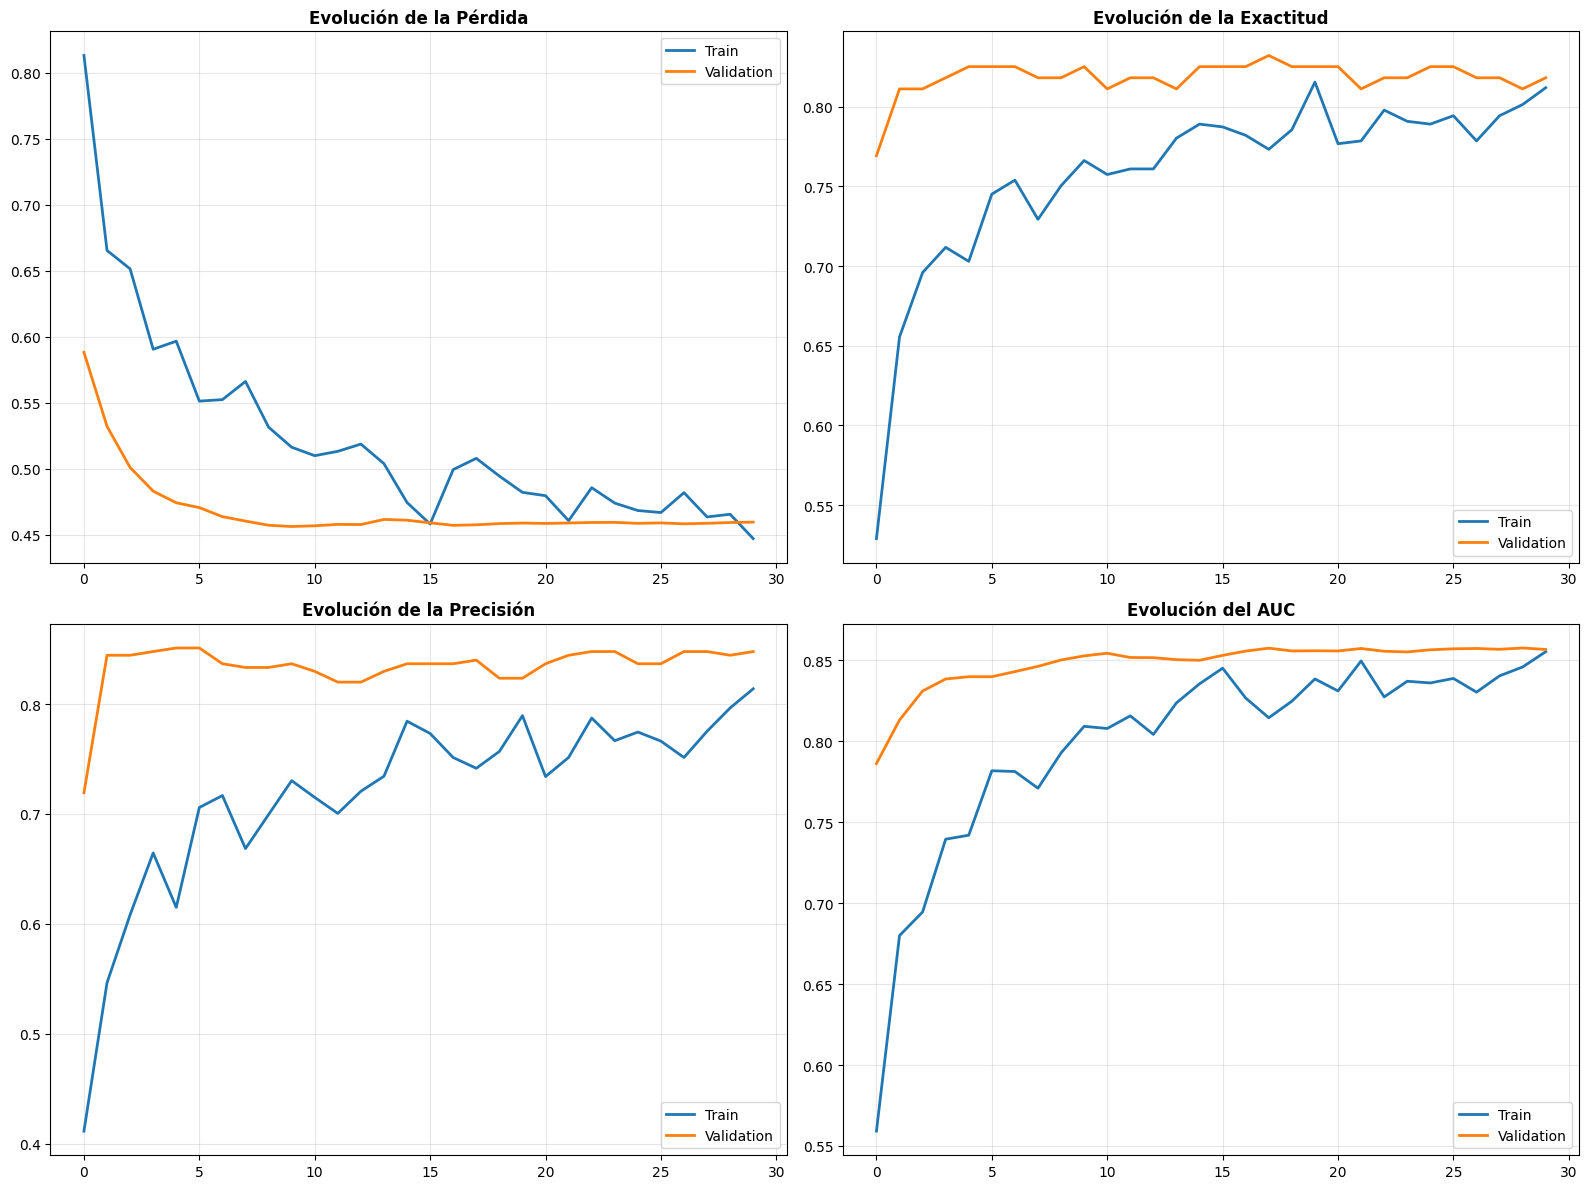

Épocas: 30
Mejor val_accuracy: 0.8322


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Evolución de la Pérdida', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 1].set_title('Evolución de la Exactitud', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
axes[1, 0].set_title('Evolución de la Precisión', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(history.history['auc'], label='Train', linewidth=2)
axes[1, 1].plot(history.history['val_auc'], label='Validation', linewidth=2)
axes[1, 1].set_title('Evolución del AUC', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Épocas: {len(history.history["loss"])}')
print(f'Mejor val_accuracy: {max(history.history["val_accuracy"]):.4f}')

## 7. Evaluación del Modelo

In [15]:
test_results = model.evaluate(X_test_scaled, y_test, verbose=0)

print('Resultados en Test Set:')
print(f'Loss: {test_results[0]:.4f}')
print(f'Accuracy: {test_results[1]:.4f}')
print(f'Precision: {test_results[2]:.4f}')
print(f'Recall: {test_results[3]:.4f}')
print(f'AUC: {test_results[4]:.4f}')

Resultados en Test Set:
Loss: 0.4554
Accuracy: 0.8101
Precision: 0.8070
Recall: 0.6667
AUC: 0.8506


In [16]:
y_pred_proba = model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print('Predicciones generadas')

Predicciones generadas


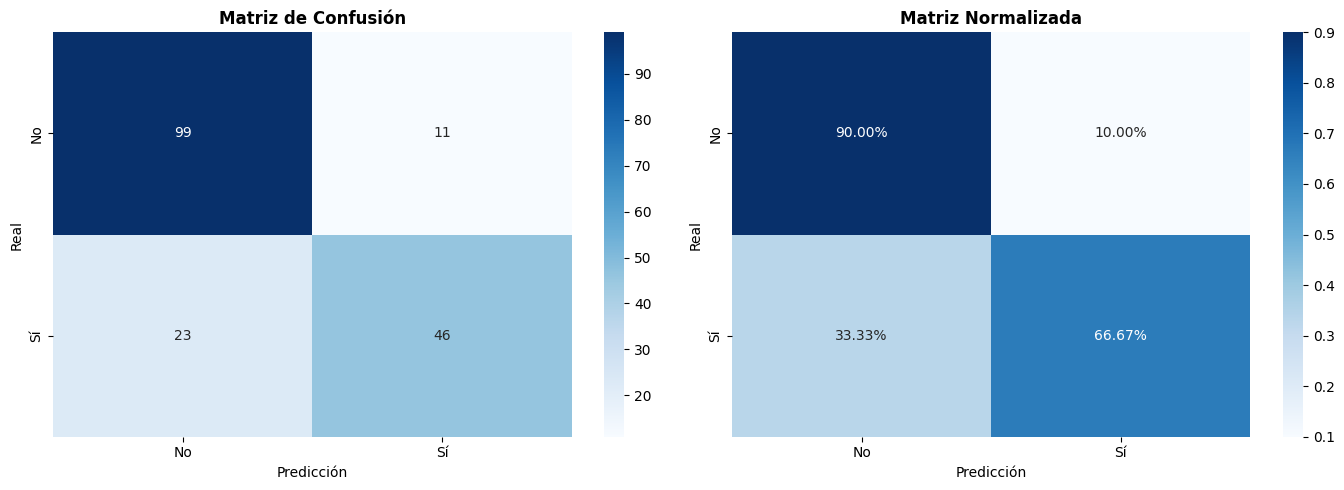

In [17]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], xticklabels=['No', 'Sí'], yticklabels=['No', 'Sí'])
ax[0].set_title('Matriz de Confusión', fontweight='bold')
ax[0].set_ylabel('Real')
ax[0].set_xlabel('Predicción')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=ax[1], xticklabels=['No', 'Sí'], yticklabels=['No', 'Sí'])
ax[1].set_title('Matriz Normalizada', fontweight='bold')
ax[1].set_ylabel('Real')
ax[1].set_xlabel('Predicción')

plt.tight_layout()
plt.show()

In [19]:
print('Reporte de Clasificación:')
print(classification_report(y_test, y_pred, target_names=['No Sobrevivió', 'Sobrevivió']))

Reporte de Clasificación:
               precision    recall  f1-score   support

No Sobrevivió       0.81      0.90      0.85       110
   Sobrevivió       0.81      0.67      0.73        69

     accuracy                           0.81       179
    macro avg       0.81      0.78      0.79       179
 weighted avg       0.81      0.81      0.81       179



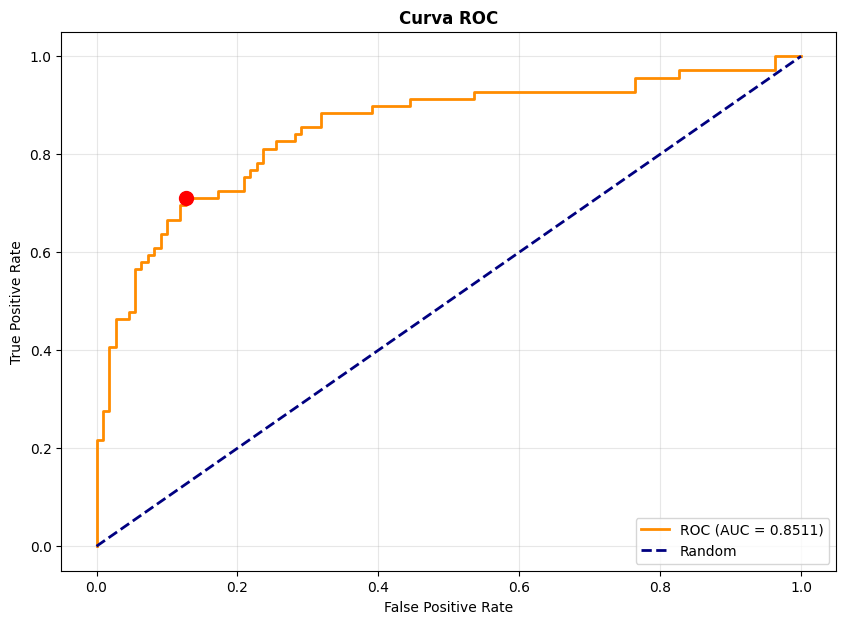

AUC Score: 0.8511


In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

optimal_idx = np.argmax(tpr - fpr)
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print(f'AUC Score: {roc_auc:.4f}')

## 8. Predicción con Nuevos Datos

In [21]:
nuevos_pasajeros = pd.DataFrame({
    'pclass': [1, 3, 2, 3],
    'sex': [0, 1, 0, 1],
    'age': [25, 30, 45, 5],
    'sibsp': [0, 0, 1, 1],
    'parch': [0, 0, 1, 1],
    'fare': [100, 8, 50, 20],
    'alone': [True, True, False, False],
    'embarked_Q': [False, False, True, False],
    'embarked_S': [True, True, False, True]
})

descripciones = [
    'Mujer joven, 1ra clase, sola',
    'Hombre adulto, 3ra clase, solo',
    'Mujer adulta, 2da clase, con familia',
    'Niño, 3ra clase, con familia'
]

#aplico el mismo escalado que se usó, no vuelvo a hacer .fit con los nuevos datos, solo .transform para evitar data leakage.
nuevos_scaled = scaler.transform(nuevos_pasajeros)
#metemos al modelo las nuevas precciones.
predicciones = model.predict(nuevos_scaled, verbose=0)

print (predicciones)
print("\n")

print('Predicciones:')
for i, (desc, prob) in enumerate(zip(descripciones, predicciones.flatten())):
    clase = 'SOBREVIVIR' if prob > 0.5 else 'NO SOBREVIVIR'
    print(f'{i+1}. {desc}')
    print(f'   Probabilidad: {prob:.2%} - {clase}\n')

[[0.96849924]
 [0.11815246]
 [0.7725368 ]
 [0.3638776 ]]


Predicciones:
1. Mujer joven, 1ra clase, sola
   Probabilidad: 96.85% - SOBREVIVIR

2. Hombre adulto, 3ra clase, solo
   Probabilidad: 11.82% - NO SOBREVIVIR

3. Mujer adulta, 2da clase, con familia
   Probabilidad: 77.25% - SOBREVIVIR

4. Niño, 3ra clase, con familia
   Probabilidad: 36.39% - NO SOBREVIVIR



In [22]:
print (nuevos_pasajeros)

   pclass  sex  age  sibsp  parch  fare  alone  embarked_Q  embarked_S
0       1    0   25      0      0   100   True       False        True
1       3    1   30      0      0     8   True       False        True
2       2    0   45      1      1    50  False        True       False
3       3    1    5      1      1    20  False       False        True


## 9. Conclusiones

### Aprendizajes Clave:

- EDA completo para identificar patrones
- Preprocesamiento: imputación, codificación, normalización
- Arquitectura MLP: 64-32-16 con Dropout
- Callbacks: EarlyStopping y ReduceLR
- Evaluación exhaustiva con múltiples métricas

### Factores de Supervivencia:

1. Sexo (mujeres ~74%)
2. Clase (1ra ~63%)
3. Edad (niños mayor prioridad)
